In [1]:
import numpy as np 
import matplotlib.pylab as plt 
from scipy.stats import multivariate_normal, norm
from scipy.optimize import minimize

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

In [70]:
sigma = 0.2
minx = 0.0 
maxx = np.pi 
ndata = 100
priorwidth = 10
nbeta = 3 # 2 parameters for the first model 
ntheta = 2 # 2 parameters for the second model
label1 = r'$at^{2} + bt + c$' # r'$A\,\textrm{sin}\,\omega t$' # 
label2 =  r'$pt^{2}+qt$' # r'$pt^{3} + qt + r$' # r'$pt^{3} + qt$' #
figlabel = 'quadratic_three_quadratic_two'

param_1_fid = np.array([-1.0, 4.0, 1.0]) # np.array([4.0, 0.75]) # 
param_2_fid = np.array([-1.0, 4.0]) # np.array([-1.0, 4.0]) # 

In [71]:
def first_model(xvalues, parameters):
    function = parameters[0] * xvalues**2 + parameters[1] * xvalues + parameters[2]
    gradient = np.vstack([xvalues**2, xvalues, np.ones(len(xvalues))]).T
    return function, gradient

def second_model(xvalues, parameters):
    function = parameters[0] * xvalues**2 + parameters[1] * xvalues 
    gradient = np.vstack([xvalues**2, xvalues]).T
    return function, gradient

In [72]:
# def first_model(xvalues, parameters):
#     function = parameters[0] * xvalues**2 + parameters[1] * xvalues + parameters[2]
#     gradient = np.vstack([xvalues**2, xvalues, np.ones(len(xvalues))]).T
#     return function, gradient

# def second_model(xvalues, parameters):
#     function = parameters[0] * xvalues**3 + parameters[1] * xvalues + parameters[2]
#     gradient = np.vstack([xvalues**3, xvalues, np.ones(len(xvalues))]).T
#     return function, gradient

In [73]:
# def first_model(xvalues, parameters):
    
#     function = parameters[0] * np.sin(parameters[1] * xvalues)
#     gradient_param_0 = np.sin(parameters[1] * xvalues)
#     gradient_param_1 = parameters[0] * xvalues * np.cos(parameters[1] * xvalues)
    
#     # this is of shape Ndata x 2 
#     gradient = np.vstack([gradient_param_0, gradient_param_1]).T
#     return function, gradient

# def second_model(xvalues, parameters):
#     function = parameters[0] * xvalues**3 + parameters[1] * xvalues
#     gradient = np.vstack([factor * xvalues**2, xvalues]).T
#     return function, gradient

In [74]:
def log_evidence_calculations(Lambda, covPrior, covNoise, data, compData):
    invterm = np.linalg.inv(Lambda + np.linalg.inv(covPrior))
    a_quant = 0.5 * compData @ invterm @ compData
    d_quant = np.linalg.slogdet(2.0 * np.pi * invterm)[1] - np.linalg.slogdet(2.0 * np.pi * covPrior)[1]
    
    chi2_comp = -0.5 * compData @ np.linalg.inv(Lambda) @ compData
    chi2_uncomp = -0.5 * data @ np.linalg.inv(covNoise) @ data
    det_comp = np.linalg.slogdet(2.0 * np.pi * Lambda)[1]
    det_uncomp = np.linalg.slogdet(2.0 * np.pi * covNoise)[1]
    
    log_evi_comp = a_quant + chi2_comp + 0.5 * (d_quant - det_comp)
    log_evi_uncomp = a_quant + chi2_uncomp + 0.5 * (d_quant - det_uncomp)
    
    return log_evi_comp, log_evi_uncomp

In [75]:
def log_likelihood_first(beta, x, data, invcov):
    model = first_model(x, beta)
    diff = data - model[0]
    chi2 = diff @ invcov @ diff
    return -0.5*chi2

def log_likelihood_second(theta, x, data, invcov):
    model = second_model(x, theta)
    diff = data - model[0]
    chi2 = diff @ invcov @ diff
    return -0.5*chi2


nll_first = lambda *args: -log_likelihood_first(*args)
nll_second = lambda *args: -log_likelihood_second(*args)

## Noise and Priors

In [76]:
noise_cov = np.diag(np.ones(ndata)*sigma**2)
noise_invcov = np.diag(1./(np.ones(ndata)*sigma**2))

In [77]:
# we will use beta to denote A and omega 
# we will use theta to denote a and b 
mean_beta = np.zeros(nbeta)
mean_theta = np.zeros(ntheta)

cov_beta = priorwidth * np.eye(nbeta)
cov_theta = priorwidth * np.eye(ntheta)

invcov_beta = np.linalg.inv(cov_beta)
invcov_theta = np.linalg.inv(cov_theta)

In [78]:
xvalues = np.linspace(minx, maxx, ndata)
model_1_fid, grad_1_fid = first_model(xvalues, param_1_fid)
model_2_fid, grad_2_fid = second_model(xvalues, param_2_fid)

In [79]:
epsilon = np.random.randn(ndata) * sigma
data = model_1_fid + epsilon

In [80]:
initial_first = param_1_fid + 0.1 * np.random.randn(nbeta)
soln_first = minimize(nll_first, initial_first, args=(xvalues, data, noise_invcov))
mle_first = soln_first.x

initial_second = param_2_fid + 0.1 * np.random.randn(ntheta)
soln_second = minimize(nll_second, initial_second, args=(xvalues, data, noise_invcov))
mle_second = soln_second.x

In [81]:
theory_mle_first, grad_mle_first = first_model(xvalues, mle_first)
theory_mle_second, grad_mle_second = second_model(xvalues, mle_second)

In [82]:
B_first = noise_invcov @ grad_1_fid # grad_mle_sin # 
B_second = noise_invcov @  grad_2_fid # grad_mle_quad #

In [83]:
X_data = data - model_1_fid # theory_mle_sin #
Y_first = B_first.T @ X_data
Y_second = B_second.T @ X_data

In [84]:
Lambda_first = B_first.T @ noise_cov @ B_first
Lambda_second = B_second.T @ noise_cov @ B_second

In [85]:
det_first = np.linalg.slogdet(2.0 * np.pi * Lambda_first)[1]
det_second = np.linalg.slogdet(2.0 * np.pi * Lambda_second)[1]

chi2_first = Y_first @ np.linalg.inv(Lambda_first) @ Y_first
chi2_second = Y_second @ np.linalg.inv(Lambda_second) @ Y_second

In [86]:
log_evi_first_comp, log_evi_first_uncomp = log_evidence_calculations(Lambda_first, cov_beta, noise_cov, X_data, Y_first)
log_evi_second_comp, log_evi_second_uncomp = log_evidence_calculations(Lambda_second, cov_theta, noise_cov, X_data, Y_second)

log_bf_comp = log_evi_first_comp - log_evi_second_comp
log_bf_uncomp = log_evi_first_uncomp - log_evi_second_uncomp
delta_bf = log_bf_comp - log_bf_uncomp

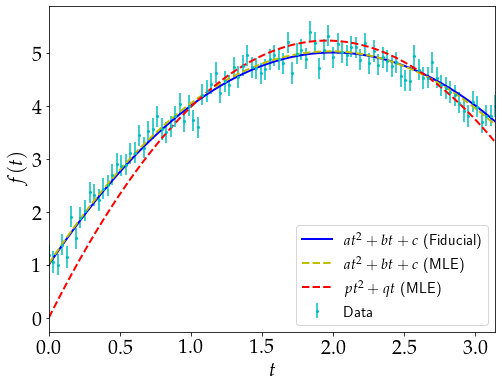

In [87]:
plt.figure(figsize = (8, 6))
plt.errorbar(xvalues, data, yerr = sigma, fmt = 'co', label = 'Data', markersize=2)
plt.plot(xvalues, model_1_fid, c = 'b', label = label1 + ' (Fiducial)', lw = 2)
# plt.plot(xvalues, model_2_fid, c = 'r', label = r'$at^{2} + bt$', lw=2)
plt.plot(xvalues, theory_mle_first, c = 'y', label = label1 + ' (MLE)', lw = 2, linestyle = '--')
plt.plot(xvalues, theory_mle_second, c = 'r', label =  label2 + ' (MLE)', lw=2, linestyle = '--')
plt.xlim(minx, maxx)
plt.ylabel(r'$f(t)$', fontsize = fontSize)
plt.xlabel(r'$t$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.savefig(f'results/{figlabel}_example_data.pdf', bbox_inches = 'tight')
plt.savefig(f'results/{figlabel}_example_data.png', bbox_inches = 'tight')
plt.show()

In [88]:
print(f'The log Bayes-Factor in the compressed case is   : {log_bf_comp:.2f}')
print(f'The log Bayes-Factor in the uncompressed case is : {log_bf_uncomp:.2f}')

The log Bayes-Factor in the compressed case is   : -7.74
The log Bayes-Factor in the uncompressed case is : -3.93


## Repeating the above $n$ times

In [89]:
# def calculate_mle(data, invcov, design):
#     invterm = np.linalg.inv(design.T @ invcov @ design)
#     mean = invterm @ design.T @ invcov @ data
#     return mean 

# MLE for sinusoidal model and quadratic model
# -----------------------------------------------------------------------------------------
#         initial_sin = param_1_fid + 0.1 * np.random.randn(nbeta)
#         soln_sin = minimize(nll_sin, initial_sin, args=(xvalues, data, noise_invcov))
#         mle_sin = soln_sin.x

#         initial_quad = param_2_fid + 0.1 * np.random.randn(ntheta)
#         soln_quad = minimize(nll_quad, initial_quad, args=(xvalues, data, noise_invcov))
#         mle_quad = soln_quad.x

#         theory_mle_sin, grad_mle_sin = model_sin(xvalues, mle_sin)
#         theory_mle_quad, grad_mle_quad = model_quad(xvalues, mle_quad)
# -----------------------------------------------------------------------------------------

In [90]:
def repetitions(ntrials):
    
    record = dict()
    record['log_evi_first_uncomp'] = list()
    record['log_evi_second_uncomp'] = list()
    record['log_evi_first_comp'] = list()
    record['log_evi_second_comp'] = list()
    record['log_bf_comp'] = list()
    record['log_bf_uncomp'] = list()
    record['delta_log_bf'] = list()
    
    for i in range(ntrials):

        epsilon = np.random.randn(ndata) * sigma
        data = model_1_fid + epsilon
        
        # for evidence calculations
        B_sin = noise_invcov @ grad_1_fid # grad_mle_sin # 
        B_quad = noise_invcov @ grad_2_fid # grad_mle_quad # 
        
        X_data = data - model_1_fid # theory_mle_sin # 
        Y_first = B_first.T @ X_data
        Y_second = B_second.T @ X_data
               
        Lambda_first = B_first.T @ noise_cov @ B_first
        Lambda_second = B_second.T @ noise_cov @ B_second

        log_evi_first_comp, log_evi_first_uncomp = log_evidence_calculations(Lambda_first, cov_beta, noise_cov, X_data, Y_first)
        log_evi_second_comp, log_evi_second_uncomp = log_evidence_calculations(Lambda_second, cov_theta, noise_cov, X_data, Y_second)
    
        # print(log_evi_quad_comp)
        
        log_bf_comp = log_evi_first_comp - log_evi_second_comp
        log_bf_uncomp = log_evi_first_uncomp - log_evi_second_uncomp
        delta_log_bf = log_bf_comp - log_bf_uncomp

        record['log_evi_first_uncomp'].append(log_evi_first_uncomp)
        record['log_evi_second_uncomp'].append(log_evi_second_uncomp)
        record['log_evi_first_comp'].append(log_evi_first_comp)
        record['log_evi_second_comp'].append(log_evi_second_comp)
        record['log_bf_comp'].append(log_bf_comp)        
        record['log_bf_uncomp'].append(log_bf_uncomp)
        record['delta_log_bf'].append(delta_log_bf)
        
    return record

In [91]:
record = repetitions(5000)

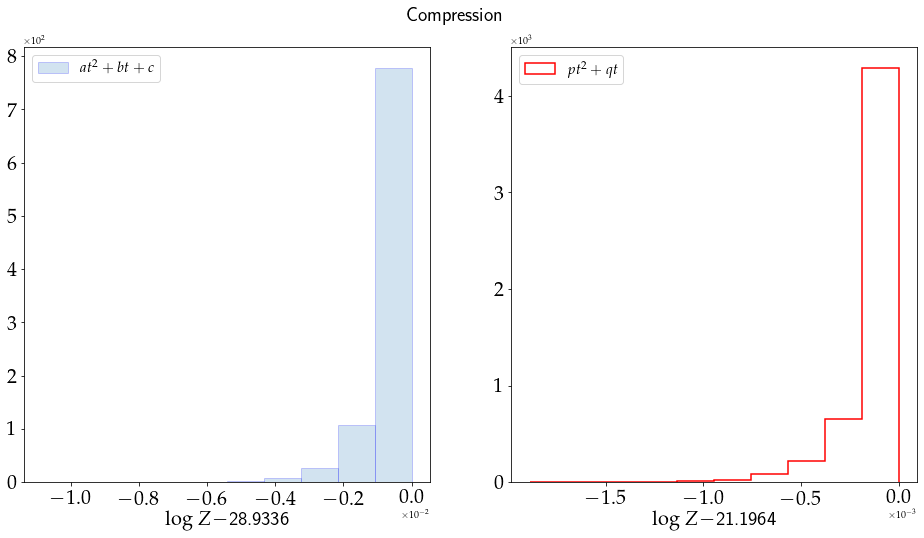

In [92]:
max_comp_first = max(record['log_evi_first_comp'])
max_comp_second = max(record['log_evi_second_comp'])

plt.figure(figsize = (16,8))

plt.suptitle('Compression', fontsize = fontSize, y=0.95)
plt.subplot(121)
plt.hist(np.asarray(record['log_evi_first_comp']) - max_comp_first, density = True, edgecolor='b', linewidth=1.0, label = label1, alpha = 0.2)
plt.xlabel(r'$\textrm{log }Z-$' + f'{abs(max_comp_first):.4f}', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(loc = 'upper left',prop={'family':'sans-serif', 'size':15})

plt.subplot(122)
plt.hist(np.asarray(record['log_evi_second_comp']) - max_comp_second, density = True, edgecolor='r', linewidth=1.5, label = label2, histtype='step')
plt.xlabel(r'$\textrm{log }Z-$' + f'{abs(max_comp_second):.4f}', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(loc = 'upper left',prop={'family':'sans-serif', 'size':15})
plt.savefig(f'results/{figlabel}_evidence_compression.pdf', bbox_inches = 'tight')
plt.savefig(f'results/{figlabel}_evidence_compression.png', bbox_inches = 'tight')
plt.show()

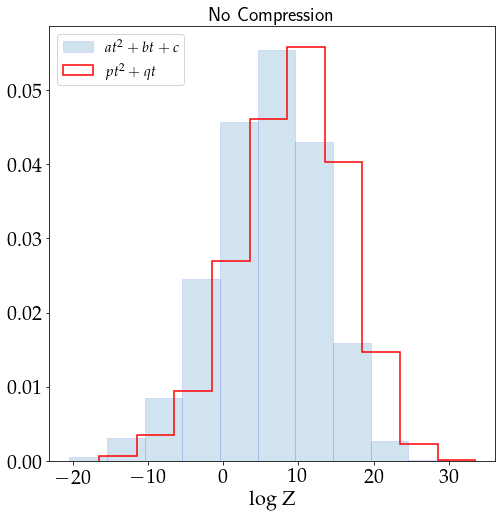

In [93]:
plt.figure(figsize = (8,8))
plt.title('No Compression', fontsize=fontSize)
plt.hist(record['log_evi_first_uncomp'], density = True, edgecolor='b', linewidth=0.5, label = label1, alpha = 0.2)
plt.hist(record['log_evi_second_uncomp'], density = True, edgecolor='r', linewidth=1.5, label = label2, histtype='step')
plt.xlabel(r'$\textrm{log Z}$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'upper left',prop={'family':'sans-serif', 'size':15})
plt.savefig(f'results/{figlabel}_evidence_no_compression.pdf', bbox_inches = 'tight')
plt.savefig(f'results/{figlabel}_evidence_no_compression.png', bbox_inches = 'tight')
plt.show()

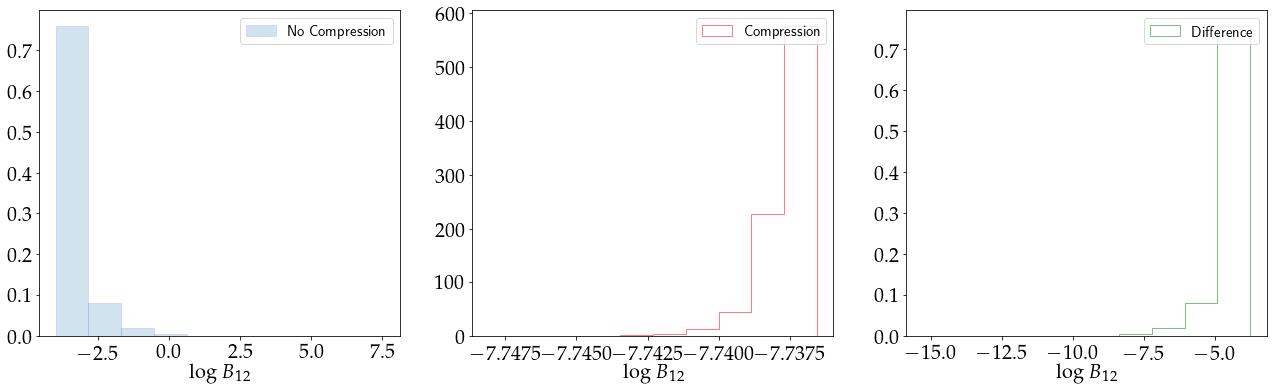

In [94]:
plt.figure(figsize = (22,6))
plt.subplot(131)
plt.hist(record['log_bf_uncomp'], density = True, edgecolor='b', linewidth=0.5, label = 'No Compression', alpha = 0.2)
plt.xlabel(r'$\textrm{log }B_{12}$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})

plt.subplot(132)
plt.hist(record['log_bf_comp'], density = True, edgecolor='r', linewidth=0.5, label = 'Compression', histtype='step')
plt.xlabel(r'$\textrm{log }B_{12}$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ticklabel_format(useOffset=False)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})

plt.subplot(133)
plt.hist(record['delta_log_bf'], density = True, edgecolor='g', linewidth=0.5, label = 'Difference', histtype='step')
plt.xlabel(r'$\textrm{log }B_{12}$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.savefig(f'results/{figlabel}_bayes_factor.pdf', bbox_inches = 'tight')
plt.savefig(f'results/{figlabel}_bayes_factor.png', bbox_inches = 'tight')
plt.show()

In [95]:
std_comp = np.std(record["log_bf_comp"])
std_uncomp = np.std(record["log_bf_uncomp"])
print(f'The standard deviation in the distribution in log-BF for the compressed case is   : {std_comp:.2e}')
print(f'The standard deviation in the distribution in log-BF for the uncompressed case is : {std_uncomp:.2e}')

The standard deviation in the distribution in log-BF for the compressed case is   : 7.39e-04
The standard deviation in the distribution in log-BF for the uncompressed case is : 6.98e-01


In [69]:
# ndata = 200, sigma = 1.0
# The standard deviation in the distribution in log-BF for the compressed case is   : 5.80e-04
# The standard deviation in the distribution in log-BF for the uncompressed case is : 1.46e-01

# ndata = 200, sigma = 0.5
# The standard deviation in the distribution in log-BF for the compressed case is   : 1.47e-04
# The standard deviation in the distribution in log-BF for the uncompressed case is : 1.42e-01

# ndata = 100, sigma = 1.0
# The standard deviation in the distribution in log-BF for the compressed case is   : 1.23e-03
# The standard deviation in the distribution in log-BF for the uncompressed case is : 1.40e-01

# ndata = 100, sigma = 0.5
# The standard deviation in the distribution in log-BF for the compressed case is   : 2.91e-04
# The standard deviation in the distribution in log-BF for the uncompressed case is : 1.47e-01

In [29]:
# 2 x sigma
5.8/1.47

3.945578231292517

In [30]:
# 2 x sigma
12.3/2.91

4.22680412371134

In [31]:
# 2 x number of data
1.23e-03 / 5.80e-04

2.1206896551724137

In [32]:
# 2 x number of data
2.91e-04/1.47e-04

1.979591836734694